In [1]:
!pip install mlxtend scikit-learn numpy pandas seaborn lightgbm xgboost

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lightgbm
import seaborn as sns

In [3]:
k2_df= pd.read_csv('/content/k2pandc_2025.10.04_11.50.12.csv')
tess_df=pd.read_csv('/content/TOI_2025.10.04_11.51.20.csv')
kepler_df = pd.read_csv('/content/cumulative_2025.10.04_11.48.14.csv')

In [4]:
# CHUNK 1 — imports & config
import os, json, numpy as np, pandas as pd
from pathlib import Path

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    confusion_matrix, classification_report
)
from joblib import dump

# where to save artifacts
ART_DIR = Path('/Users/amulpoudel/Developer/beyond-blue/models/exo_classification/artifacts')
ART_DIR.mkdir(parents=True, exist_ok=True)

print("✅ imports ready")


✅ imports ready


In [5]:
# CHUNK 2 — mappers (safe column picker)

import numpy as np
import pandas as pd

UNIFIED_COLS = [
    "source","object_id","host_id",
    "period_days","epoch_bjd","duration_hours","depth_ppm",
    "planet_radius_re","insolation_earth","teq_k","impact",
    "st_teff_k","st_logg_cgs","st_radius_rs","st_mass_ms",
    "mag_tess","mag_kepler","ra_deg","dec_deg",
    "disposition","label"
]
LAB_MAP = {"CONFIRMED":2, "CANDIDATE":1, "FALSE POSITIVE":0}

def pick(df: pd.DataFrame, *cands, fallback=None):
    """Return the first existing column as a Series; else a NaN Series (or fallback if given)."""
    for c in cands:
        if c in df.columns:
            return df[c]
    if fallback is not None:
        return fallback
    # default: NaN series with correct index
    return pd.Series(np.nan, index=df.index)

def to_num(s):
    return pd.to_numeric(s, errors="coerce") if s is not None else s

def make_tess(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)
    out["source"] = "TESS-TOI"

    out["object_id"] = pick(df, "toi", "TOI").astype(str)
    out["host_id"]   = pick(df, "tid", "tic_id", "TIC ID").astype(str)

    out["period_days"]    = to_num(pick(df, "pl_orbper", "Orbital Period [days]"))
    out["epoch_bjd"]      = to_num(pick(df, "pl_tranmid", "Planet Transit Midpoint [BJD]"))
    out["duration_hours"] = to_num(pick(df, "pl_trandurh", "Planet Transit Duration [hours]"))
    out["depth_ppm"]      = to_num(pick(df, "pl_trandep", "Planet Transit Depth [ppm]"))
    out["planet_radius_re"] = to_num(pick(df, "pl_rade", "Planet Radius [R_Earth]"))
    out["insolation_earth"] = to_num(pick(df, "pl_insol", "Planet Insolation [Earth flux]"))
    out["teq_k"]            = to_num(pick(df, "pl_eqt", "Planet Equilibrium Temperature [K]"))
    out["impact"] = np.nan  # not in default TOI CSV

    out["st_teff_k"]   = to_num(pick(df, "st_teff", "Stellar Effective Temperature [K]"))
    out["st_logg_cgs"] = to_num(pick(df, "st_logg", "Stellar log(g) [cm/s**2]"))
    out["st_radius_rs"]= to_num(pick(df, "st_rad", "Stellar Radius [R_Sun]"))
    out["st_mass_ms"]  = np.nan

    out["mag_tess"]    = to_num(pick(df, "st_tmag", "TESS Magnitude"))
    out["mag_kepler"]  = np.nan

    out["ra_deg"]  = to_num(pick(df, "ra", "RA [deg]"))
    out["dec_deg"] = to_num(pick(df, "dec", "Dec [deg]"))

    disp_raw = pick(df, "tfopwg_disp", "TFOPWG Disposition")
    disp_raw = disp_raw.astype(str).str.upper() if disp_raw is not None else pd.Series(index=df.index, dtype="object")
    map_toi = {"CP":"CONFIRMED","KP":"CONFIRMED","PC":"CANDIDATE","APC":"CANDIDATE","FP":"FALSE POSITIVE","FA":"FALSE POSITIVE"}
    out["disposition"] = disp_raw.map(map_toi).fillna(disp_raw)
    out["label"] = out["disposition"].map(LAB_MAP)

    return out.reindex(columns=UNIFIED_COLS)

def make_kepler(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)
    out["source"] = "Kepler-KOI"

    out["object_id"] = pick(df, "kepoi_name", "KOI Name")
    out["host_id"]   = pick(df, "kepid", "Kepler Identification or KepID").astype(str)

    out["period_days"] = to_num(pick(df, "koi_period", "Orbital Period (days)"))
    koi_time0   = to_num(pick(df, "koi_time0", "Transit Epoch in BJD"))
    koi_time0bk = to_num(pick(df, "koi_time0bk", "Transit Epoch (BJD - 2,454,833.0)"))
    out["epoch_bjd"] = np.where(~pd.isna(koi_time0), koi_time0, koi_time0bk + 2454833)

    out["duration_hours"] = to_num(pick(df, "koi_duration", "Transit Duration (hours)"))
    out["depth_ppm"]      = to_num(pick(df, "koi_depth", "Transit Depth (parts per million)"))
    out["planet_radius_re"] = to_num(pick(df, "koi_prad", "Planetary Radius (Earth radii)"))
    out["insolation_earth"] = to_num(pick(df, "koi_insol", "Insolation Flux [Earth flux]", "Insolation Flux [Earth Flux]"))
    out["teq_k"]            = to_num(pick(df, "koi_teq", "Equilibrium Temperature (Kelvin)"))
    out["impact"]           = to_num(pick(df, "koi_impact", "Impact Parameter"))

    out["st_teff_k"]   = to_num(pick(df, "koi_steff", "Stellar Effective Temperature (Kelvin)"))
    out["st_logg_cgs"] = to_num(pick(df, "koi_slogg", "Stellar Surface Gravity (log10(cm s-2)"))
    out["st_radius_rs"]= to_num(pick(df, "koi_srad", "Stellar Radius (solar radii)"))
    out["st_mass_ms"]  = to_num(pick(df, "koi_smass", "Stellar Mass (solar mass)")) if ("koi_smass" in df.columns or "Stellar Mass (solar mass)" in df.columns) else np.nan

    out["mag_tess"]   = np.nan
    out["mag_kepler"] = to_num(pick(df, "koi_kepmag", "Kepler-band (mag)", "Kepler-band [mag]"))

    out["ra_deg"]  = to_num(pick(df, "ra", "RA (deg)", "RA [decimal]"))
    out["dec_deg"] = to_num(pick(df, "dec", "Dec (deg)", "Dec [decimal]"))

    disp = pick(df, "koi_disposition", "Exoplanet Archive Disposition")
    disp = disp.astype(str).str.upper().replace({"NOT DISPOSITIONED": np.nan}) if disp is not None else pd.Series(index=df.index, dtype="object")
    out["disposition"] = disp
    out["label"] = out["disposition"].map(LAB_MAP)

    return out.reindex(columns=UNIFIED_COLS)

def make_k2(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)
    out["source"] = "K2-pandc"

    out["object_id"] = pick(df, "pl_name", "k2_name")
    out["host_id"]   = pick(df, "tic_id")

    out["period_days"]    = to_num(pick(df, "pl_orbper", "Orbital Period [days]"))
    out["epoch_bjd"]      = to_num(pick(df, "pl_tranmid", "Time of Conjunction (Transit Midpoint) [days]"))
    out["duration_hours"] = to_num(pick(df, "pl_trandur", "Transit Duration [hours]"))

    depth_pct = to_num(pick(df, "pl_trandep", "Transit Depth [%]"))
    out["depth_ppm"]      = depth_pct * 1e4  # % → ppm

    out["planet_radius_re"] = to_num(pick(df, "pl_rade", "Candidate Radius [Earth radii]"))
    out["insolation_earth"] = to_num(pick(df, "pl_insol", "Insolation Flux [Earth Flux]"))
    out["teq_k"]            = to_num(pick(df, "pl_eqt", "Equilibrium Temperature [K]"))
    out["impact"]           = to_num(pick(df, "pl_imppar", "Impact Parameter"))

    out["st_teff_k"]   = to_num(pick(df, "st_teff", "Effective Temperature [K]"))
    out["st_logg_cgs"] = to_num(pick(df, "st_logg", "Stellar Surface Gravity"))
    out["st_radius_rs"]= to_num(pick(df, "st_rad", "Stellar Radius [Solar radii]"))
    out["st_mass_ms"]  = to_num(pick(df, "st_mass", "Stellar Mass [Solar mass]")) if ("st_mass" in df.columns or "Stellar Mass [Solar mass]" in df.columns) else np.nan

    out["mag_tess"]   = to_num(pick(df, "sy_tmag", "TESS Magnitude"))
    out["mag_kepler"] = to_num(pick(df, "sy_kepmag", "Kepler-band [mag]"))

    out["ra_deg"]  = to_num(pick(df, "ra", "RA [decimal]"))
    out["dec_deg"] = to_num(pick(df, "dec", "Dec [decimal]"))

    disp_raw = pick(df, "disposition", "Archive Disposition")
    disp_raw = disp_raw.astype(str).str.upper() if disp_raw is not None else pd.Series(index=df.index, dtype="object")
    disp_norm = disp_raw.replace({
        "FALSE POSITIVE [CANDIDATE]": "FALSE POSITIVE",
        "REFUTED [PLANET]": "FALSE POSITIVE",
        "CONFIRMED [PLANET]": "CONFIRMED"
    })
    out["disposition"] = disp_norm
    out["label"] = out["disposition"].map(LAB_MAP)

    return out.reindex(columns=UNIFIED_COLS)

print("✅ mappers patched with safe column picker")


✅ mappers patched with safe column picker


In [6]:
# CHUNK 3 — build unified df
uni = pd.concat([make_tess(tess_df), make_kepler(kepler_df), make_k2(k2_df)], ignore_index=True)
uni = uni[~uni["label"].isna() & ~uni["period_days"].isna()].copy()
print(uni.shape)
uni.shape


(21098, 21)


(21098, 21)

In [7]:
# CHUNK 4 — targets + features
# targets
y_multi = uni["label"].astype(int)          # 0/1/2
y_bin   = (uni["label"] == 2).astype(int)   # 1=CONFIRMED vs 0=(CANDIDATE+FP)

# features: numeric only; drop IDs/labels
drop_cols = ["disposition","label","source","object_id","host_id"]
num_cols = [c for c in uni.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(uni[c])]
X = uni[num_cols].copy()

# optional gentle log1p for skew
for c in ["period_days","duration_hours","depth_ppm","planet_radius_re","insolation_earth","teq_k","st_teff_k","st_radius_rs","st_mass_ms"]:
    if c in X.columns:
        X[c] = np.where(np.isfinite(X[c]) & (X[c] > 0), np.log1p(X[c]), X[c])

print(len(num_cols), "numeric features")


16 numeric features


In [8]:
# CHUNK 5 — stratified split (binary & multiclass kept separate)
X_tr_b, X_te_b, y_tr_b, y_te_b = train_test_split(X, y_bin,   test_size=0.2, stratify=y_bin,   random_state=42)
X_tr_m, X_te_m, y_tr_m, y_te_m = train_test_split(X, y_multi, test_size=0.2, stratify=y_multi, random_state=42)

print("Binary train size:", X_tr_b.shape, "| test size:", X_te_b.shape)
print("Multi  train size:", X_tr_m.shape, "| test size:", X_te_m.shape)


Binary train size: (16878, 16) | test size: (4220, 16)
Multi  train size: (16878, 16) | test size: (4220, 16)


In [9]:
# CHUNK 6 — choose model + pipelines
def pick_model():
    try:
        from lightgbm import LGBMClassifier
        return "LightGBM", LGBMClassifier(
            n_estimators=800, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            class_weight="balanced", random_state=42
        )
    except Exception:
        try:
            from xgboost import XGBClassifier
            return "XGBoost", XGBClassifier(
                n_estimators=800, learning_rate=0.05, max_depth=6,
                subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
                eval_metric="logloss", tree_method="hist", random_state=42
            )
        except Exception:
            from sklearn.ensemble import HistGradientBoostingClassifier
            return "HistGB", HistGradientBoostingClassifier(
                max_depth=None, learning_rate=0.05, max_iter=800, random_state=42
            )

model_name_b, clf_b = pick_model()
model_name_m, clf_m = pick_model()
print(f"Binary model: {model_name_b} | Multiclass model: {model_name_m}")

pre = ColumnTransformer([("num_impute", SimpleImputer(strategy="median"), X.columns)], remainder="drop")
pipe_b = Pipeline([("pre", pre), ("clf", clf_b)])
pipe_m = Pipeline([("pre", pre), ("clf", clf_m)])


Binary model: LightGBM | Multiclass model: LightGBM


In [10]:
# CHUNK 7 — 5-fold CV on training data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc  = cross_val_score(pipe_b, X_tr_b, y_tr_b, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_f1m  = cross_val_score(pipe_m, X_tr_m, y_tr_m, cv=cv, scoring="f1_macro", n_jobs=-1)

print(f"[Binary] 5-fold ROC-AUC: {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")
print(f"[Multi ] 5-fold Macro-F1: {cv_f1m.mean():.4f} ± {cv_f1m.std():.4f}")


[Binary] 5-fold ROC-AUC: 0.9441 ± 0.0026
[Multi ] 5-fold Macro-F1: 0.7857 ± 0.0052


In [11]:
# CHUNK 8 — fit & evaluate
pipe_b.fit(X_tr_b, y_tr_b)
proba_b = pipe_b.predict_proba(X_te_b)[:,1] if hasattr(pipe_b.named_steps["clf"], "predict_proba") else None
pred_b  = pipe_b.predict(X_te_b)

bin_metrics = {
    "roc_auc": float(roc_auc_score(y_te_b, proba_b)) if proba_b is not None else None,
    "pr_auc":  float(average_precision_score(y_te_b, proba_b)) if proba_b is not None else None,
    "f1":      float(f1_score(y_te_b, pred_b))
}
cm_b = confusion_matrix(y_te_b, pred_b)

pipe_m.fit(X_tr_m, y_tr_m)
pred_m = pipe_m.predict(X_te_m)
multi_metrics = {"f1_macro": float(f1_score(y_te_m, pred_m, average="macro"))}
cm_m = confusion_matrix(y_te_m, pred_m, labels=[0,1,2])

print("\n=== Binary (Confirmed vs Not) ===")
print(f"ROC-AUC: {bin_metrics['roc_auc']:.4f}" if bin_metrics["roc_auc"] is not None else "ROC-AUC: n/a")
print(f"PR-AUC:  {bin_metrics['pr_auc']:.4f}"  if bin_metrics["pr_auc"]  is not None else "PR-AUC: n/a")
print(f"F1:      {bin_metrics['f1']:.4f}")
print("Confusion Matrix [rows=true, cols=pred]:\n", cm_b)

print("\n=== Multiclass (0=FP,1=PC,2=CP) ===")
print(f"Macro-F1: {multi_metrics['f1_macro']:.4f}")
print("Confusion Matrix [rows=true, cols=pred, order 0,1,2]:\n", cm_m)
print("\nClassification report:\n", classification_report(y_te_m, pred_m, digits=4))


[LightGBM] [Info] Number of positive: 5030, number of negative: 11848
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 16878, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 16878, number of used features: 16
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Binary (Confirmed vs Not) ===
ROC-AUC: 0.9482
PR-AUC:  0.8929
F1:      0.8079
Confusion Matrix [rows=true, cols=pred]:
 [[2659  303]
 [ 200 1058]]

=== Multiclass (0=FP,1=PC,2=CP) ===
Macro-F1: 0.7927
Confusion Matrix [rows=true, cols=pred, order 0,1,2]:
 [[1012  200   70]
 [ 214 1277  189]
 [  53  157 1048]]

Classification report:
               precision    recall  f1-score   support

           0     0.7912    0.7894    0.7903      1282
           1     0.7815    0.7601    0.7707      1680
           2     0.8018    0.8331    0.8172      1258

    accuracy                         0.7908      4220
   macro avg     0.7915    0.7942    0.7927      4220
weighted avg     0.7905    0.7908    0.7905      4220



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


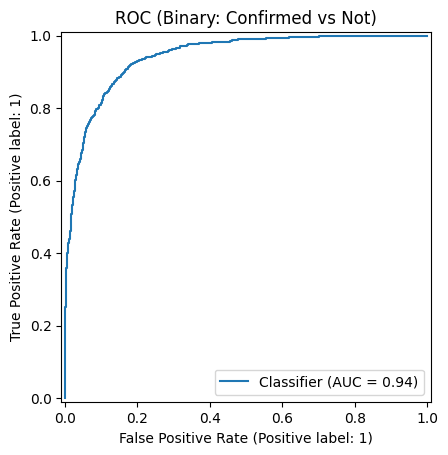

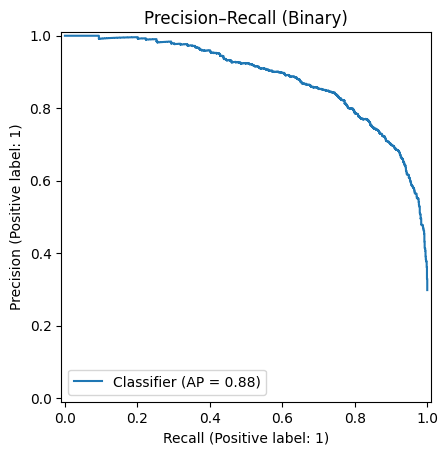

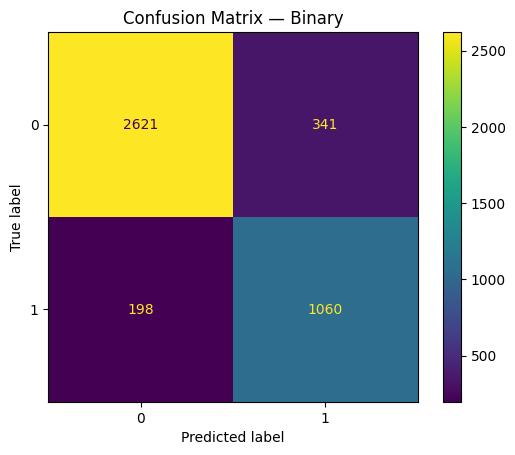

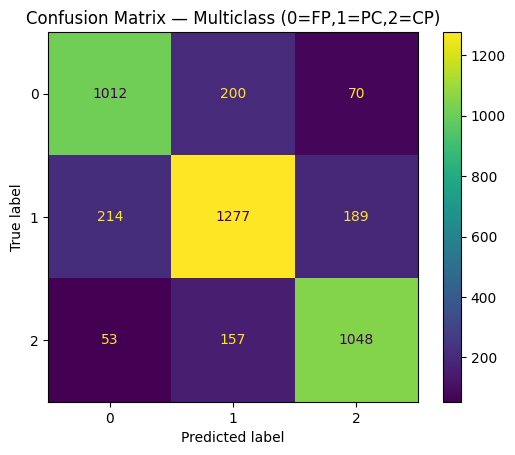

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, roc_auc_score, average_precision_score

# Predict (binary)
proba_b = pipe_b.predict_proba(X_te_b)[:, 1] if hasattr(pipe_b.named_steps["clf"], "predict_proba") else None
pred_b  = pipe_b.predict(X_te_b)

# Predict (multiclass)
pred_m = pipe_m.predict(X_te_m)

# ROC
if proba_b is not None:
    RocCurveDisplay.from_predictions(y_te_b, proba_b)
    plt.title("ROC (Binary: Confirmed vs Not)")
    plt.show()

# PR
if proba_b is not None:
    PrecisionRecallDisplay.from_predictions(y_te_b, proba_b)
    plt.title("Precision–Recall (Binary)")
    plt.show()

# Confusion matrices
ConfusionMatrixDisplay.from_predictions(y_te_b, pred_b)
plt.title("Confusion Matrix — Binary")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_te_m, pred_m, labels=[0,1,2])
plt.title("Confusion Matrix — Multiclass (0=FP,1=PC,2=CP)")
plt.show()


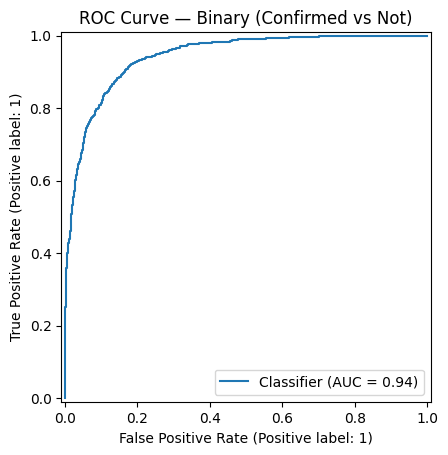

NameError: name 'pipe_b_fit' is not defined

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# --- ROC–AUC (binary) ---
if proba_b is not None:
    RocCurveDisplay.from_predictions(y_te_b, proba_b)
    plt.title("ROC Curve — Binary (Confirmed vs Not)")
    plt.show()

# --- Loss / validation curves (boosting history) ---
def plot_eval_history(pipeline, title):
    est = pipeline.named_steps["clf"]
    # XGBoost scikit wrapper
    if hasattr(est, "evals_result"):
        try:
            hist = est.evals_result()
            for dataset, metrics in hist.items():
                for metric_name, values in metrics.items():
                    plt.plot(values, label=f"{dataset} - {metric_name}")
            plt.xlabel("Boosting rounds")
            plt.ylabel("Loss / Metric")
            plt.title(title)
            plt.legend()
            plt.show()
            return
        except Exception:
            pass
    # LightGBM scikit wrapper
    if hasattr(est, "evals_result_"):
        hist = est.evals_result_
        for dataset, metrics in hist.items():
            for metric_name, values in metrics.items():
                plt.plot(values, label=f"{dataset} - {metric_name}")
        plt.xlabel("Boosting rounds")
        plt.ylabel("Loss / Metric")
        plt.title(title)
        plt.legend()
        plt.show()
        return
    print("No eval history available (likely sklearn HistGB or no eval_set supported).")

plot_eval_history(pipe_b_fit, "Loss Curve — Binary (logloss / mlogloss)")
plot_eval_history(pipe_m_fit, "Loss Curve — Multiclass (mlogloss)")


In [14]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, f1_score

# Binary report (threshold = 0.5 on predict_proba)
print("=== Classification Report — Binary (Confirmed vs Not) ===")
print(classification_report(y_te_b, pred_b, digits=4))
if proba_b is not None:
    print(f"ROC-AUC: {roc_auc_score(y_te_b, proba_b):.4f}")
    print(f"PR-AUC : {average_precision_score(y_te_b, proba_b):.4f}")
print(f"F1     : {f1_score(y_te_b, pred_b):.4f}")

# Multiclass report (0=FALSE POSITIVE, 1=CANDIDATE, 2=CONFIRMED)
print("\n=== Classification Report — Multiclass (0=FP,1=PC,2=CP) ===")
print(classification_report(y_te_m, pred_m, digits=4))


=== Classification Report — Binary (Confirmed vs Not) ===
              precision    recall  f1-score   support

           0     0.9298    0.8849    0.9068      2962
           1     0.7566    0.8426    0.7973      1258

    accuracy                         0.8723      4220
   macro avg     0.8432    0.8637    0.8520      4220
weighted avg     0.8781    0.8723    0.8741      4220

ROC-AUC: 0.9428
PR-AUC : 0.8844
F1     : 0.7973

=== Classification Report — Multiclass (0=FP,1=PC,2=CP) ===
              precision    recall  f1-score   support

           0     0.7912    0.7894    0.7903      1282
           1     0.7815    0.7601    0.7707      1680
           2     0.8018    0.8331    0.8172      1258

    accuracy                         0.7908      4220
   macro avg     0.7915    0.7942    0.7927      4220
weighted avg     0.7905    0.7908    0.7905      4220



In [ ]:
# pip install lightgbm mlxtend
features = uni.columns.tolist()
from lightgbm import LGBMClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.metrics import accuracy_score, f1_score
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------
# 1) Base LightGBM model for feature search
# -----------------------------------------
lgb_params_fs = dict(
    objective="multiclass",
    num_class=3,
    learning_rate=0.05,
    n_estimators=300,         # keep modest for search speed
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    metric="multi_logloss"
)
lgb_fs = LGBMClassifier(**lgb_params_fs)

# -----------------------------------------
# 2) Exhaustive Feature Selector
#    (adjust min/max to control runtime)
# -----------------------------------------
efs = ExhaustiveFeatureSelector(
    estimator=lgb_fs,
    min_features=4,
    max_features=8,           # try 6–10 depending on time
    scoring="f1_macro",
    cv=3,                     # 3-fold CV for speed; 5 for robustness
    n_jobs=-1,
    print_progress=True
)

print(f"Running EFS over {len(features)} features...")
efs = efs.fit(X_tr_b, y_tr_b)  # binary target for feature selection

best_idx = list(efs.best_idx_)
best_feats = [features[i] for i in best_idx]
print("\nBest subset size:", len(best_feats))
print("Selected features:", best_feats)
print("Best CV f1_macro:", round(efs.best_score_, 4))

# -----------------------------------------
# 3) Retrain stronger LGBM on selected feats
# -----------------------------------------
lgb_params_final = dict(
    objective="multiclass",
    num_class=3,
    learning_rate=0.05,
    n_estimators=1000,        # larger now that subset fixed
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    metric="multi_logloss"
)
lgb_sel = LGBMClassifier(**lgb_params_final)
lgb_sel.fit(X_tr_b[:, best_idx], y_tr_b)

# -----------------------------------------
# 4) Evaluate on test (selected feats only)
# -----------------------------------------
y_pred = lgb_sel.predict(X_te_b[:, best_idx])
acc = accuracy_score(y_te_b, y_pred)
f1m = f1_score(y_te_b, y_pred, average="macro")
print(f"\nTEST (selected subset) — Acc: {acc:.4f}  MacroF1: {f1m:.4f}")

# -----------------------------------------
# 5) Feature importance (gain + permutation)
# -----------------------------------------
# LightGBM "gain" importance
gain_importances = lgb_sel.booster_.feature_importance(importance_type="gain")
order = np.argsort(gain_importances)[::-1]
print("\nLightGBM Gain Importances (selected subset):")
for i in order:
    print(f"  {best_feats[i]:<20s}  {gain_importances[i]:.6f}")

plt.figure(figsize=(7,6))
plt.barh(np.array(best_feats)[order][::-1], gain_importances[order][::-1])
plt.title("LightGBM Feature Importance (Gain) — Selected Subset")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()

# Model-agnostic permutation importance (on test set)
perm = permutation_importance(
    lgb_sel, X_te_b[:, best_idx], y_te_b,
    scoring="f1_macro", n_repeats=10, random_state=42, n_jobs=-1
)
p_order = np.argsort(perm.importances_mean)[::-1]
print("\nPermutation Importance (F1 macro drop) — Selected Subset:")
for i in p_order:
    print(f"  {best_feats[i]:<20s}  mean={perm.importances_mean[i]:.6f}  std={perm.importances_std[i]:.6f}")

plt.figure(figsize=(7,6))
plt.barh(np.array(best_feats)[p_order][::-1], perm.importances_mean[p_order][::-1])
plt.title("Permutation Importance (F1 macro) — Selected Subset")
plt.xlabel("Mean Importance (score drop)")
plt.tight_layout()
plt.show()


Running EFS over 21 features...
